<h1 style="text-align: center;"><strong>Análisis exploratorio de datos (EDA)</strong></h1>


> # Etapa 1: Análisis descriptivo

---


- Instalación de librerias


In [1]:
# %pip install pyodbc
# %pip install ipython
# %pip install edaSQL
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install scipy

1. **Importamos los paquetes necesarios**


In [2]:
import edaSQL  # conexión a base datos
import pandas as pd
import numpy as np
import seaborn as sns  # visualización
import matplotlib.pyplot as plt  # visualización
from scipy import stats  # Datos atípicos

2.  **Establecer conexión con base datos**


In [3]:
try:
    edasql = edaSQL.SQL(printAll=True)

    edasql.connectToDataBase(
        server="localhost",
        database="TecnoNic_DW",
        user="sa",
        password="password",
        sqlDriver="ODBC Driver 17 for SQL Server"
    )
except Exception as e:
    print("A ocurrido un error con:", e)

========== Connected to DataBase Successfully ===========
Server:  localhost
DataBase:  TecnoNic_DW
User :  sa
Password :  password


2. **Cargamos la data en “dataframes”**


In [4]:
# Función para cargar las tablas a un dataframe
def loadTable(table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, edasql.dbConnection)


# Cargar las tablas en DataFrames
df_cliente = loadTable("dbo.dim_Cliente")
df_AreaEnvio = loadTable("dbo.dim_AreaEnvio")
df_ofertas = loadTable("dbo.dim_Ofertas")
df_pedido = loadTable("dbo.dim_Pedido")
df_producto = loadTable("dbo.dim_Producto")
df_ubicacion = loadTable("dbo.dim_Ubicacion")
df_envio = loadTable("dbo.Fact_Envio")

- Se fusionaron los conjuntos de datos para estructurar la información.


In [5]:
df_envio = df_envio \
    .merge(df_pedido, left_on='Pedido Key', right_on='Pedido Key', how='left', suffixes=('', '_pedido')) \
    .merge(df_cliente, left_on='Cliente Key', right_on='Cliente Key', how='left', suffixes=('', '_cliente')) \
    .merge(df_ofertas, left_on='Oferta Key', right_on='Oferta Key', how='left', suffixes=('', '_ofertas')) \
    .merge(df_AreaEnvio, left_on='Area Envio Key', right_on='Area Envio Key', how='left', suffixes=('', '_area')) \
    .merge(df_producto, left_on='Producto Key', right_on='Producto Key', how='left', suffixes=('', '_producto')) \
    .merge(df_ubicacion, left_on='Ubicacion Key', right_on='Ubicacion Key', how='left', suffixes=('', '_ubicacion'))

- Definir índice


In [6]:
df_envio = df_envio.set_index("Envio Key")

- Limpieza de datos


In [7]:
# Definir nombre completo del cliente
df_envio['NombreCliente'] = df_envio['Nombre'] + ' ' + df_envio['Apellido']
df_envio.drop(columns=["Nombre", "Apellido"], inplace=True)

- Eliminar columnas innecesarias


In [9]:
columnsKeep = [
    'Envio Key', 'Metodo Pago', 'Direccion Pago', 'Precio Unitario', 'Cantidad', 'Estado', 'Fecha Pedido', 'NombreCliente', 'Puntos Fidelidad', 'Nombre_ofertas', 'Descuento',
    'Area', 'Costo Envio', 'Nombre_producto', 'Nombre Marca', 'Nombre Categoria', 'Empresa Envio', 'Metodo Envio', 'Estado envio', 'Ciudad', 'Fecha Envio', 'Fecha Entrega'
]

# Lista de todas las columnas en el DataFrame
allColumns = df_envio.columns.tolist()

# Lista de columnas a eliminar
columnsDrop = [col for col in allColumns if col not in columnsKeep]
df_envio = df_envio.drop(columns=columnsDrop)
df_envio.columns

Index(['Empresa Envio', 'Metodo Envio', 'Fecha Envio', 'Fecha Entrega',
       'Metodo Pago', 'Direccion Pago', 'Precio Unitario', 'Cantidad',
       'Estado', 'Fecha Pedido', 'Ciudad', 'Puntos Fidelidad',
       'Nombre_ofertas', 'Descuento', 'Area', 'Costo Envio', 'Nombre_producto',
       'Nombre Categoria', 'Nombre Marca', 'NombreCliente'],
      dtype='object')

- Organizar dataframe


In [10]:
columnOrder = [
    'NombreCliente', 'Puntos Fidelidad', # Cliente
    'Empresa Envio', 'Metodo Envio', 'Area', 'Costo Envio',  # Envio
    'Fecha Envio', 'Fecha Entrega', 'Fecha Pedido',  # Fechas importantes
    'Nombre_producto',   'Nombre Categoria', 'Nombre Marca',  # producto
    'Precio Unitario', 'Cantidad', 'Metodo Pago', 'Nombre_ofertas', 'Descuento'  # pedido
]

# Ordenar las columnas del DataFrame
df_envio = df_envio[columnOrder]
df_envio.columns

Index(['NombreCliente', 'Puntos Fidelidad', 'Empresa Envio', 'Metodo Envio',
       'Area', 'Costo Envio', 'Fecha Envio', 'Fecha Entrega', 'Fecha Pedido',
       'Nombre_producto', 'Nombre Categoria', 'Nombre Marca',
       'Precio Unitario', 'Cantidad', 'Metodo Pago', 'Nombre_ofertas',
       'Descuento'],
      dtype='object')

3. **Características de un DataFrame**


- Mostrar las primeras filas


In [11]:
df_envio.head(5)

,NombreCliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Nombre_producto,Nombre Categoria,Nombre Marca,Precio Unitario,Cantidad,Metodo Pago,Nombre_ofertas,Descuento
Envio Key,,,,,,,,,,,,,,,,,
0,Muffin Baudinot,10,USPS,envio economico,island,87.07,2024-04-15,2023-09-27,2019-08-06,digital voice recorder,Electronics,TechMasters,957.59,38,Tarjeta de crédito,Unknown,0.00
1,Tamera McAvaddy,83,USPS,envio estandar,island,87.07,2024-04-09,2024-01-15,2022-02-23,wearable camera,Cameras,TechFusion,625.85,22,PayPal,Oferta de descuento en laptops,49.08
2,Casey Arney,69,DHL,envio estandar,desert,24.40,2024-02-26,2023-09-26,2019-06-23,smart pen,Keyboards and Mice,CyberTech,925.57,33,Tarjeta de crédito,Promoción de smartphones,24.07
3,Tonnie Douthwaite,3,UPS,envio estandar,coastal,81.20,2023-09-23,2024-04-29,2022-03-22,network switch,Gadgets,GizmoWorks,519.64,23,Tarjeta de crédito,Unknown,0.00
4,Robbert Manueli,87,FedEx,envio estandar,desert,24.40,2023-06-12,2023-06-15,2019-11-02,POS system,Virtual Reality,DigitalSolutions,1858.28,21,Efectivo,Promoción de smartphones,4.78


- Mostrar las ultimas filas


In [12]:
df_envio.tail(5)

,NombreCliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Nombre_producto,Nombre Categoria,Nombre Marca,Precio Unitario,Cantidad,Metodo Pago,Nombre_ofertas,Descuento
Envio Key,,,,,,,,,,,,,,,,,
995,Mirabel McGuinness,6,Amazon Logistics,envio economico,rural,42.02,2024-01-07,2023-09-06,2020-09-26,wireless earbuds,Audio Devices,GadgetGalaxy,1346.53,30,Tarjeta de crédito,Promoción de smartphones,24.07
996,Amie Wisker,60,Amazon Logistics,envio economico,central,15.15,2024-03-26,2024-05-31,2023-08-17,graphic tablet,Drones,TechPro,1725.47,4,Tarjeta de crédito,Unknown,0.00
997,Elton Addy,24,UPS,envio estandar,valley,15.68,2023-12-18,2023-12-03,2019-04-13,VR headset,Monitors,GadgetZone,1303.04,13,PayPal,Promoción de smartphones,4.78
998,Pooh Founds,74,Amazon Logistics,envio expreso,downtown,80.77,2023-08-28,2024-05-26,2021-09-25,keyboard,Software,TechGenius,853.78,12,Tarjeta de crédito,Oferta de descuento en laptops,49.08
999,Robby O'Neill,16,DHL,envio expreso,mountain,19.47,2024-01-05,2023-11-20,2022-12-27,external hard drive,External Hard Drives,DigitalDreams,1402.34,12,Efectivo,Promoción de smartphones,24.07


- Mostrar el número de filas y columnas del DataFrame ventas.


In [14]:
# El maenejo de f: no funciona 
try:
    print(f"Número de filas del dataframe: {df_envio.shape[0]} \nNúmero de columnas del dataframe: {df_envio.shape[1]}")
except AttributeError:
    print("Advertencia: El objeto no parece en anacando Juypter")
except Exception as e:
    print(f"Se produjo un error: {e}")

Número de filas del dataframe: 1000 
Número de columnas del dataframe: 17


- Resumen de la información interna sobre el DataFrame.


In [15]:
df_envio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   NombreCliente     1000 non-null   object        
 1   Puntos Fidelidad  1000 non-null   int64         
 2   Empresa Envio     1000 non-null   object        
 3   Metodo Envio      1000 non-null   object        
 4   Area              1000 non-null   object        
 5   Costo Envio       1000 non-null   float64       
 6   Fecha Envio       1000 non-null   datetime64[ns]
 7   Fecha Entrega     1000 non-null   datetime64[ns]
 8   Fecha Pedido      1000 non-null   datetime64[ns]
 9   Nombre_producto   1000 non-null   object        
 10  Nombre Categoria  1000 non-null   object        
 11  Nombre Marca      1000 non-null   object        
 12  Precio Unitario   1000 non-null   float64       
 13  Cantidad          1000 non-null   int64         
 14  Metodo Pago       1000 non-nul

- Análisis descriptivos


In [16]:
df_envio.describe()

,Puntos Fidelidad,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Precio Unitario,Cantidad,Descuento
count,1000.000000,1000.00000,1000,1000,1000,1000.000000,1000.000000,1000.000000
mean,50.210000,50.50802,2023-12-09 02:49:55.199999744,2023-12-11 19:30:43.199999744,2015-11-27 07:42:14.400000,964.216340,24.502000,29.675170
min,0.000000,15.15000,2023-06-10 00:00:00,2023-06-10 00:00:00,1753-01-01 00:00:00,0.000000,0.000000,0.000000
25%,26.000000,19.47000,2023-09-08 00:00:00,2023-09-04 00:00:00,2020-03-26 00:00:00,458.140000,12.000000,4.780000
50%,51.000000,42.02000,2023-12-10 00:00:00,2023-12-16 00:00:00,2021-07-15 12:00:00,934.380000,24.000000,24.070000
75%,76.000000,80.77000,2024-03-12 00:00:00,2024-03-11 06:00:00,2022-09-30 06:00:00,1484.485000,37.000000,49.080000
max,100.000000,87.07000,2024-06-09 00:00:00,2024-06-08 00:00:00,2023-12-30 00:00:00,1998.130000,50.000000,62.000000
std,28.733003,29.91585,NaN,NaN,NaN,594.841217,14.568055,22.658088


### Informe Estadístico de Pedidos y Envíos

#
#
#
#

- Elimanr columnas innecesarias


In [18]:
df_envio.columns

Index(['NombreCliente', 'Puntos Fidelidad', 'Empresa Envio', 'Metodo Envio',
       'Area', 'Costo Envio', 'Fecha Envio', 'Fecha Entrega', 'Fecha Pedido',
       'Nombre_producto', 'Nombre Categoria', 'Nombre Marca',
       'Precio Unitario', 'Cantidad', 'Metodo Pago', 'Nombre_ofertas',
       'Descuento'],
      dtype='object')

In [19]:
df_envio = df_envio.drop(columns=[
    "Nombre Marca",
    "Nombre Categoria"
], axis=1)
df_envio.head()

,NombreCliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Nombre_producto,Precio Unitario,Cantidad,Metodo Pago,Nombre_ofertas,Descuento
Envio Key,,,,,,,,,,,,,,,
0,Muffin Baudinot,10,USPS,envio economico,island,87.07,2024-04-15,2023-09-27,2019-08-06,digital voice recorder,957.59,38,Tarjeta de crédito,Unknown,0.00
1,Tamera McAvaddy,83,USPS,envio estandar,island,87.07,2024-04-09,2024-01-15,2022-02-23,wearable camera,625.85,22,PayPal,Oferta de descuento en laptops,49.08
2,Casey Arney,69,DHL,envio estandar,desert,24.40,2024-02-26,2023-09-26,2019-06-23,smart pen,925.57,33,Tarjeta de crédito,Promoción de smartphones,24.07
3,Tonnie Douthwaite,3,UPS,envio estandar,coastal,81.20,2023-09-23,2024-04-29,2022-03-22,network switch,519.64,23,Tarjeta de crédito,Unknown,0.00
4,Robbert Manueli,87,FedEx,envio estandar,desert,24.40,2023-06-12,2023-06-15,2019-11-02,POS system,1858.28,21,Efectivo,Promoción de smartphones,4.78


- Renombrar columnas


In [20]:
df_envio.columns

Index(['NombreCliente', 'Puntos Fidelidad', 'Empresa Envio', 'Metodo Envio',
       'Area', 'Costo Envio', 'Fecha Envio', 'Fecha Entrega', 'Fecha Pedido',
       'Nombre_producto', 'Precio Unitario', 'Cantidad', 'Metodo Pago',
       'Nombre_ofertas', 'Descuento'],
      dtype='object')

In [21]:
df_envio = df_envio.rename(columns={
    "NombreCliente": "Cliente",
    "Nombre_producto": "Producto",
    "Nombre_ofertas": "Oferta",}
)
df_envio.tail(5)

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento
Envio Key,,,,,,,,,,,,,,,
995,Mirabel McGuinness,6,Amazon Logistics,envio economico,rural,42.02,2024-01-07,2023-09-06,2020-09-26,wireless earbuds,1346.53,30,Tarjeta de crédito,Promoción de smartphones,24.07
996,Amie Wisker,60,Amazon Logistics,envio economico,central,15.15,2024-03-26,2024-05-31,2023-08-17,graphic tablet,1725.47,4,Tarjeta de crédito,Unknown,0.00
997,Elton Addy,24,UPS,envio estandar,valley,15.68,2023-12-18,2023-12-03,2019-04-13,VR headset,1303.04,13,PayPal,Promoción de smartphones,4.78
998,Pooh Founds,74,Amazon Logistics,envio expreso,downtown,80.77,2023-08-28,2024-05-26,2021-09-25,keyboard,853.78,12,Tarjeta de crédito,Oferta de descuento en laptops,49.08
999,Robby O'Neill,16,DHL,envio expreso,mountain,19.47,2024-01-05,2023-11-20,2022-12-27,external hard drive,1402.34,12,Efectivo,Promoción de smartphones,24.07


- Visualización final del DataFrame


In [22]:
df_envio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Cliente           1000 non-null   object        
 1   Puntos Fidelidad  1000 non-null   int64         
 2   Empresa Envio     1000 non-null   object        
 3   Metodo Envio      1000 non-null   object        
 4   Area              1000 non-null   object        
 5   Costo Envio       1000 non-null   float64       
 6   Fecha Envio       1000 non-null   datetime64[ns]
 7   Fecha Entrega     1000 non-null   datetime64[ns]
 8   Fecha Pedido      1000 non-null   datetime64[ns]
 9   Producto          1000 non-null   object        
 10  Precio Unitario   1000 non-null   float64       
 11  Cantidad          1000 non-null   int64         
 12  Metodo Pago       1000 non-null   object        
 13  Oferta            1000 non-null   object        
 14  Descuento         1000 non-nul

4. **Modificación de un DataFrame**


- Eliminar datos duplicados


In [24]:
df_envio.count()

Cliente             1000
Puntos Fidelidad    1000
Empresa Envio       1000
Metodo Envio        1000
Area                1000
Costo Envio         1000
Fecha Envio         1000
Fecha Entrega       1000
Fecha Pedido        1000
Producto            1000
Precio Unitario     1000
Cantidad            1000
Metodo Pago         1000
Oferta              1000
Descuento           1000
dtype: int64

In [26]:
df_envio = df_envio.drop_duplicates()
df_envio.count()

Cliente             1000
Puntos Fidelidad    1000
Empresa Envio       1000
Metodo Envio        1000
Area                1000
Costo Envio         1000
Fecha Envio         1000
Fecha Entrega       1000
Fecha Pedido        1000
Producto            1000
Precio Unitario     1000
Cantidad            1000
Metodo Pago         1000
Oferta              1000
Descuento           1000
dtype: int64

- Agregar columnas al dataframe


In [27]:
# Agregar el costo final del pedido tomado en cuenta envio, descuento y la cantidad en respecto a su precio unitario.
df_envio['Costo Final'] = (
    (df_envio['Cantidad'] * df_envio['Precio Unitario'] +
     df_envio['Costo Envio']) * (1 - df_envio['Descuento'] / 100)
).round(2)
df_envio.head()

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
0,Muffin Baudinot,10,USPS,envio economico,island,87.07,2024-04-15,2023-09-27,2019-08-06,digital voice recorder,957.59,38,Tarjeta de crédito,Unknown,0.00,36475.49
1,Tamera McAvaddy,83,USPS,envio estandar,island,87.07,2024-04-09,2024-01-15,2022-02-23,wearable camera,625.85,22,PayPal,Oferta de descuento en laptops,49.08,7055.36
2,Casey Arney,69,DHL,envio estandar,desert,24.40,2024-02-26,2023-09-26,2019-06-23,smart pen,925.57,33,Tarjeta de crédito,Promoción de smartphones,24.07,23210.44
3,Tonnie Douthwaite,3,UPS,envio estandar,coastal,81.20,2023-09-23,2024-04-29,2022-03-22,network switch,519.64,23,Tarjeta de crédito,Unknown,0.00,12032.92
4,Robbert Manueli,87,FedEx,envio estandar,desert,24.40,2023-06-12,2023-06-15,2019-11-02,POS system,1858.28,21,Efectivo,Promoción de smartphones,4.78,37181.77


- Acceso por filas y columnas a un DataFrame


    Seleccionar las primeras 10 filas y las columnas de la 0 a la 5 (inclusive)


In [28]:
firstRow = df_envio.iloc[:10, :6]
firstRow

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio
Envio Key,,,,,,
0,Muffin Baudinot,10,USPS,envio economico,island,87.07
1,Tamera McAvaddy,83,USPS,envio estandar,island,87.07
2,Casey Arney,69,DHL,envio estandar,desert,24.40
3,Tonnie Douthwaite,3,UPS,envio estandar,coastal,81.20
4,Robbert Manueli,87,FedEx,envio estandar,desert,24.40
5,Unknown Unknown,0,UPS,envio expreso,island,87.07
6,Halley Malmar,86,FedEx,envio expreso,rural,42.02
7,Krystal Vivien,16,UPS,envio estandar,valley,15.68
8,Beale McAnulty,29,UPS,envio expreso,mountain,19.47


     Seleccionar las últimas 5 filas y las columnas de la 10 a la 15 (inclusive)


In [29]:
lastRow = df_envio.iloc[-5:, 10:16]
lastRow

,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,
995,1346.53,30,Tarjeta de crédito,Promoción de smartphones,24.07,30704.51
996,1725.47,4,Tarjeta de crédito,Unknown,0.00,6917.03
997,1303.04,13,PayPal,Promoción de smartphones,4.78,16144.74
998,853.78,12,Tarjeta de crédito,Oferta de descuento en laptops,49.08,5258.07
999,1402.34,12,Efectivo,Promoción de smartphones,24.07,12792.34


    Seleccionar columnas 'Cliente', 'Producto', 'Fecha Pedido' y 'Cantidad' para todas las filas


In [30]:
selectedColumns = df_envio.loc[:, [
    'Cliente', 'Producto', 'Fecha Pedido', 'Cantidad']]
selectedColumns.head(5)

,Cliente,Producto,Fecha Pedido,Cantidad
Envio Key,,,,
0,Muffin Baudinot,digital voice recorder,2019-08-06,38
1,Tamera McAvaddy,wearable camera,2022-02-23,22
2,Casey Arney,smart pen,2019-06-23,33
3,Tonnie Douthwaite,network switch,2022-03-22,23
4,Robbert Manueli,POS system,2019-11-02,21


- Selección a través de condicionales


     Personas que han pagado a través de PayPal


In [31]:
PayPal = df_envio.loc[df_envio['Metodo Pago'] == 'PayPal']
print(f"{len(PayPal)} Personas han pagado a través de PayPal")

233 Personas han pagado a través de PayPal


    Filas donde el Area sea 'suburb' y la Cantidad sea mayor a 2


In [34]:
urbana_cantidad = df_envio.loc[(
    df_envio['Area'] == 'suburb') & (df_envio['Cantidad'] > 40)]
urbana_cantidad

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
45,Libbi Illing,4,DHL,envio economico,suburb,77.74,2024-02-04,2023-09-30,2022-11-10,thermal printer,998.48,41,Tarjeta de crédito,Venta flash de dispositivos electrónicos,62.00,15585.86
54,Yves Platt,9,DHL,envio economico,suburb,77.74,2023-08-24,2023-08-09,2022-12-07,POS system,730.78,45,PayPal,Unknown,0.00,32962.84
105,Derby Costan,80,FedEx,envio expreso,suburb,77.74,2024-03-04,2023-09-04,2021-12-25,router,82.61,45,Transferencia bancaria,Oferta de descuento en laptops,49.08,1932.51
212,Tessy Gosnold,24,FedEx,envio estandar,suburb,77.74,2023-09-06,2023-09-10,2022-05-26,printer,1791.05,42,Tarjeta de crédito,Unknown,0.00,75301.84
264,Zechariah Rodenhurst,34,FedEx,envio expreso,suburb,77.74,2024-06-03,2024-05-26,2021-08-29,portable charger,1568.51,50,Tarjeta de crédito,Oferta de descuento en laptops,49.08,39973.85
265,Catriona Sterling,91,DHL,envio economico,suburb,77.74,2024-01-14,2024-06-04,2021-04-04,satellite phone,1964.43,48,Transferencia bancaria,Oferta de descuento en laptops,49.08,48053.40
267,Rosella Malbon,10,DHL,envio economico,suburb,77.74,2024-06-03,2024-05-09,2021-11-14,smart ring,691.87,44,Transferencia bancaria,Unknown,0.00,30520.02
325,Alia Ida,7,UPS,envio expreso,suburb,77.74,2023-07-18,2023-08-30,2023-12-13,thermal printer,125.84,45,Transferencia bancaria,Unknown,0.00,5740.54
399,Nonna Fraczak,43,Amazon Logistics,envio estandar,suburb,77.74,2023-07-07,2024-05-11,2022-05-07,smart scale,139.04,44,Transferencia bancaria,Venta flash de dispositivos electrónicos,62.00,2354.29


     Seleccionar todos los pedidos donde la cantidad de productos sea mayor a 45, el precio unitario sea menor a 230, y el área sea 'Central' o 'suburb'


In [35]:
order = df_envio[(df_envio['Cantidad'] > 45) &
                 (df_envio['Precio Unitario'] < 230) &
                 (df_envio['Area'].isin(['suburb', 'central']))]
order

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
247,Gwendolyn Wyche,50,UPS,envio estandar,central,15.15,2024-03-07,2023-07-13,2021-04-24,keyboard,96.3,49,Efectivo,Oferta de descuento en laptops,49.08,2410.48


     Filtrar los pedidos cuyo costo de envío sea menor al promedio del costo de envío, y la fidelidad de puntos sea mayor a 90


In [33]:
averageCost = df_envio['Costo Envio'].mean()
orderTwo = df_envio[(df_envio['Costo Envio'] < averageCost) &
                    (df_envio['Puntos Fidelidad'] > 90)]
orderTwo

,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
24,Cinderella Northen,92,UPS,envio estandar,rural,42.02,2024-01-03,2023-09-25,2023-11-10,router,1206.62,10,Tarjeta de crédito,Oferta de descuento en laptops,49.08,6165.51
46,Fredra Malster,100,Amazon Logistics,envio estandar,rural,42.02,2024-04-27,2023-11-11,2022-11-25,camera,883.10,36,Efectivo,Promoción de smartphones,4.78,30311.97
47,Gill Lanfranchi,98,Amazon Logistics,envio economico,desert,24.40,2023-07-03,2023-09-17,2020-06-15,printer,965.51,43,Tarjeta de crédito,Oferta de descuento en laptops,49.08,21152.85
61,Hamel Elster,94,DHL,envio estandar,mountain,19.47,2023-09-30,2023-10-20,2019-02-28,GPS device,651.86,7,Transferencia bancaria,Descuento en productos de audio y video,27.40,3326.89
92,Adlai McCurtin,97,Amazon Logistics,envio estandar,central,15.15,2023-12-08,2023-10-07,2023-10-03,gaming mouse,910.15,26,Transferencia bancaria,Promoción de smartphones,24.07,17979.50
95,Marguerite Howie,99,USPS,envio economico,rural,42.02,2023-09-17,2023-07-08,2022-03-05,network switch,616.75,6,Efectivo,Venta flash de dispositivos electrónicos,62.00,1422.16
106,Cherida Chopin,97,DHL,envio estandar,mountain,19.47,2024-02-16,2024-05-22,2019-05-09,thermal printer,1847.73,20,Tarjeta de crédito,Promoción de smartphones,4.78,35206.71
124,Brant Cassie,98,UPS,envio economico,desert,24.40,2024-01-22,2023-07-27,2021-11-11,monitor,796.72,2,Efectivo,Promoción de smartphones,24.07,1228.43
132,Allie Stuther,99,DHL,envio expreso,central,15.15,2023-07-04,2024-02-06,2020-12-31,fitness tracker,282.72,8,Tarjeta de crédito,Unknown,0.00,2276.91


4. **Visualizacion gráfico de barra Costo de envío por área**


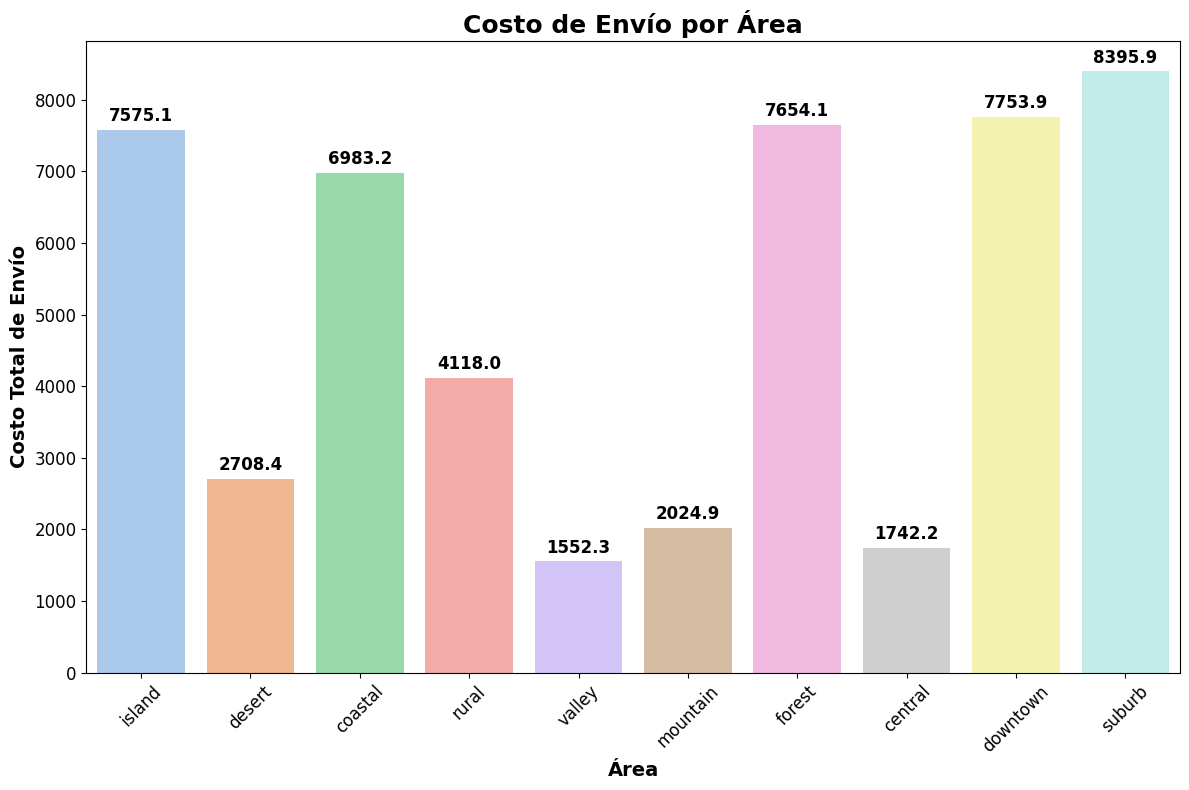

In [36]:
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Area', y='Costo Envio', data=df_envio,
                      estimator=sum, ci=None, palette="pastel")
plt.title('Costo de Envío por Área', fontsize=18, fontweight='bold')
plt.xlabel('Área', fontsize=14, fontweight='bold')
plt.ylabel('Costo Total de Envío', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Añadir valores en la parte superior de las barras
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10),
                     textcoords='offset points',
                     fontsize=12,
                     color='black',
                     fontweight='bold')

plt.show()

$$
Informe
$$




5. **Visualizacion gráficos de pastel de la distribución de pago**


In [42]:
df_envio['Metodo Pago'].unique()

array(['Tarjeta de crédito', 'PayPal', 'Efectivo',
       'Transferencia bancaria', 'Unknown'], dtype=object)

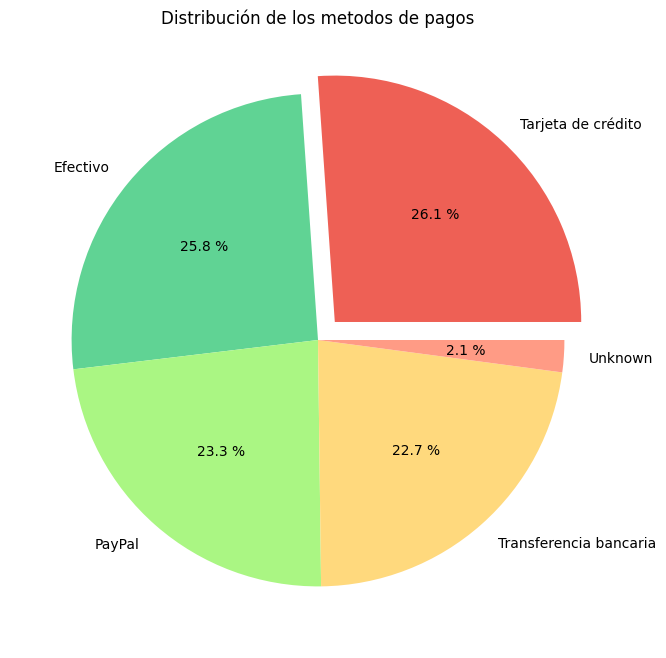

In [45]:
# Set the explode parameter for the pie chart
explode = (0.1, 0, 0, 0, 0)
plt.figure(figsize=(8, 8))
colors = ["#EE6055", "#60D394", "#AAF683", "#FFD97D", "#FF9B85"]
df_envio['Metodo Pago'].value_counts().plot.pie(
    autopct='%0.1f %%', explode=explode, colors=colors
)
plt.title('Distribución de los metodos de pagos')
plt.ylabel('')
plt.show()

$$
Informe
$$



> # Etapa 2: Ajuste de tipo de variables


1. **Tipos de datos**


In [46]:
df_envio.dtypes

Cliente                     object
Puntos Fidelidad             int64
Empresa Envio               object
Metodo Envio                object
Area                        object
Costo Envio                float64
Fecha Envio         datetime64[ns]
Fecha Entrega       datetime64[ns]
Fecha Pedido        datetime64[ns]
Producto                    object
Precio Unitario            float64
Cantidad                     int64
Metodo Pago                 object
Oferta                      object
Descuento                  float64
Costo Final                float64
dtype: object

1. Manejo de Fechas:


- Extraer componentes de fecha como día, mes, año, etc. solo para las columnas de interés


In [47]:
Order = df_envio.copy()
Order['Fecha Pedido'] = pd.to_datetime(Order['Fecha Pedido'])
Order['dia'] = Order['Fecha Pedido'].dt.day
Order['mes'] = Order['Fecha Pedido'].dt.month
Order['año'] = Order['Fecha Pedido'].dt.year

# Mostrar el DataFrame resultante
Order[['Cliente', 'Producto', 'Fecha Pedido', 'dia', 'mes', 'año']].head(5)

,Cliente,Producto,Fecha Pedido,dia,mes,año
Envio Key,,,,,,
0,Muffin Baudinot,digital voice recorder,2019-08-06,6,8,2019
1,Tamera McAvaddy,wearable camera,2022-02-23,23,2,2022
2,Casey Arney,smart pen,2019-06-23,23,6,2019
3,Tonnie Douthwaite,network switch,2022-03-22,22,3,2022
4,Robbert Manueli,POS system,2019-11-02,2,11,2019


- Cálculo de fechas


    Dias Transcurridos desde el envio hasta la fecha de entrega


In [53]:
shipment = df_envio.copy()
shipment['Dias Transcurridos desde el envio'] = (
    shipment['Fecha Entrega'] - shipment['Fecha Envio']).dt.days
# Las fechas son generadas asi que suponemos que no todas las fechas llevan una secuencia
shipment['Dias Transcurridos desde el envio'] = shipment['Dias Transcurridos desde el envio'].abs()
shipment[['Cliente', 'Producto', 'Cantidad', 'Fecha Entrega',
          'Fecha Envio', 'Dias Transcurridos desde el envio']].tail(6)

,Cliente,Producto,Cantidad,Fecha Entrega,Fecha Envio,Dias Transcurridos desde el envio
Envio Key,,,,,,
994,Arlyne Jansa,USB hub,39,2024-02-03,2023-08-26,161
995,Mirabel McGuinness,wireless earbuds,30,2023-09-06,2024-01-07,123
996,Amie Wisker,graphic tablet,4,2024-05-31,2024-03-26,66
997,Elton Addy,VR headset,13,2023-12-03,2023-12-18,15
998,Pooh Founds,keyboard,12,2024-05-26,2023-08-28,272
999,Robby O'Neill,external hard drive,12,2023-11-20,2024-01-05,46


2.  **Manejo de Categorías**:


In [54]:
df_envio['Area'] = df_envio['Area'].astype('category')
df_envio['Producto'] = df_envio['Producto'].astype('category')
df_envio['Metodo Pago'] = df_envio['Metodo Pago'].astype('category')
df_envio['Oferta'] = df_envio['Oferta'].astype('category')

Las categorías que se han definido en el DataFrame `df_envio` tienen un significado específico y se utilizan para clasificar los datos de manera ordenada y eficiente. Aquí está el informe sobre el significado de estas categorías:

1. **Area:** Esta categoría representa las diferentes áreas o regiones a las que se envían los productos. En este caso, se han identificado cuatro áreas distintas donde se realizan los envíos.

2. **Producto:** Esta categoría se refiere a los distintos tipos de productos que se envían. El DataFrame actualmente contiene información sobre diez productos diferentes que pueden estar siendo enviados.

3. **Método de Pago:** Esta categoría indica los diferentes métodos utilizados para realizar el pago de los productos. El DataFrame registra cinco métodos de pago diferentes que pueden estar asociados a los envíos.

4. **Oferta:** Aquí se registran las diferentes ofertas o promociones aplicadas a los envíos. El DataFrame muestra información sobre cuatro ofertas específicas que pueden haber sido utilizadas en los envíos.

Estas categorías son útiles para organizar y analizar los datos de envíos de manera más precisa y para realizar análisis posteriores sobre patrones de compra, preferencias de pago, efectividad de ofertas, entre otros aspectos relevantes para la gestión de envíos y ventas.


In [55]:
df_envio.dtypes

Cliente                     object
Puntos Fidelidad             int64
Empresa Envio               object
Metodo Envio                object
Area                      category
Costo Envio                float64
Fecha Envio         datetime64[ns]
Fecha Entrega       datetime64[ns]
Fecha Pedido        datetime64[ns]
Producto                  category
Precio Unitario            float64
Cantidad                     int64
Metodo Pago               category
Oferta                    category
Descuento                  float64
Costo Final                float64
dtype: object

> # Etapa 3: Detección y tratamientos de datos ausentes:


- Comprobar valores nulos


In [56]:
df_envio.isna().sum()

Cliente             0
Puntos Fidelidad    0
Empresa Envio       0
Metodo Envio        0
Area                0
Costo Envio         0
Fecha Envio         0
Fecha Entrega       0
Fecha Pedido        0
Producto            0
Precio Unitario     0
Cantidad            0
Metodo Pago         0
Oferta              0
Descuento           0
Costo Final         0
dtype: int64

## Si bien no se observan valores nulos en el conjunto de datos, se procederá a utilizar el método dropna() para eliminar filas con valores faltantes en cualquier columna.


In [57]:
df_envio = df_envio.dropna()

> # Etapa 4: Identificación y tratamiento de datos atípicos:


1. **Histograma**


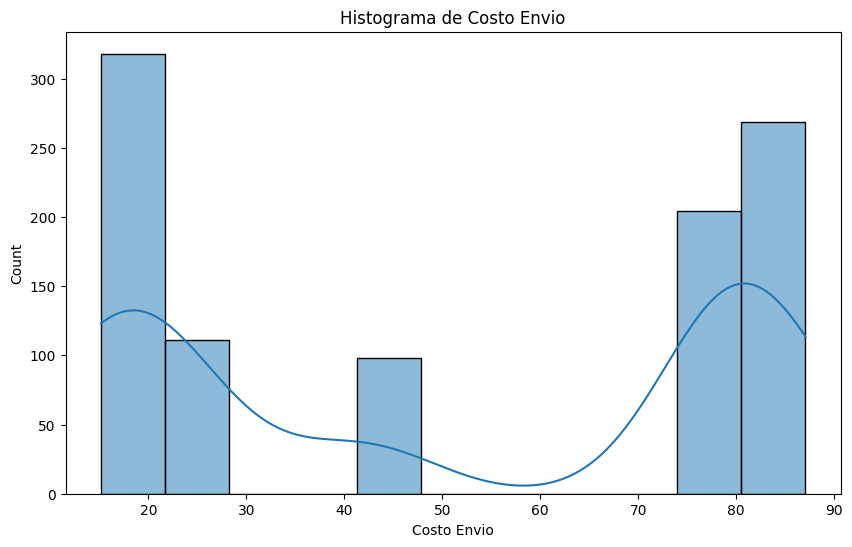

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(df_envio['Costo Envio'], kde=True)
plt.title('Histograma de Costo Envio')
plt.show()

### informe

2. **BoxPlot**


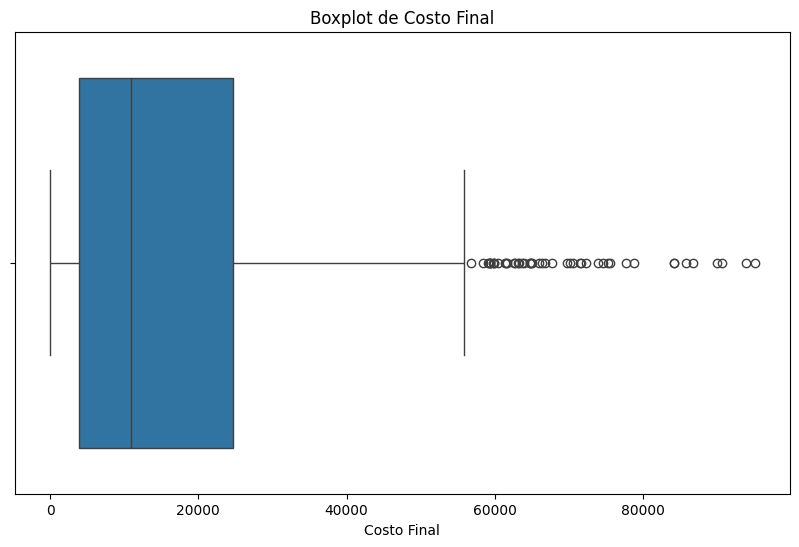

In [69]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_envio['Costo Final'])
plt.title('Boxplot de Costo Final')
plt.show()

informe


3. **Z-Score**


In [71]:
outliers = df_envio.copy()
outliers['Z-score'] = np.abs(stats.zscore(df_envio['Costo Final']))
outliers_zscore = outliers[outliers['Z-score'] > 3]
print("Outliers basandos en Z-score:")
outliers_zscore

Outliers basandos en Z-score:


,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final,Z-score
Envio Key,,,,,,,,,,,,,,,,,
94,Donni Fassmann,1,DHL,envio economico,central,15.15,2023-11-14,2023-12-13,2022-02-24,portable charger,1904.04,50,PayPal,Promoción de smartphones,4.78,90665.77,4.130340
183,Dione Donohue,81,UPS,envio estandar,mountain,19.47,2023-07-01,2024-05-31,2019-03-23,smart scale,1967.08,50,Efectivo,Descuento en productos de audio y video,27.40,71419.14,3.047959
212,Tessy Gosnold,24,FedEx,envio estandar,suburb,77.74,2023-09-06,2023-09-10,2022-05-26,printer,1791.05,42,Tarjeta de crédito,Unknown,0.00,75301.84,3.266312
225,Earvin Taffley,62,Amazon Logistics,envio economico,central,15.15,2024-02-23,2023-12-16,2022-12-08,headphones,1995.27,47,Tarjeta de crédito,Unknown,0.00,93792.84,4.306199
251,Rosana Authers,11,FedEx,envio estandar,forest,79.73,2024-02-18,2023-10-04,2019-05-15,satellite phone,1998.13,45,PayPal,Unknown,0.00,89995.58,4.092651
308,Dorie Mathan,28,FedEx,envio expreso,desert,24.40,2023-07-23,2023-08-24,2021-07-09,gaming mouse,1863.13,42,PayPal,Promoción de smartphones,4.78,74534.27,3.223146
332,Alexia Rayburn,69,DHL,envio economico,desert,24.40,2023-09-11,2024-01-28,2019-10-31,Unknown,1522.78,47,PayPal,Unknown,0.00,71595.06,3.057852
527,Rorie Barras,55,UPS,envio economico,desert,24.40,2023-07-08,2023-06-20,2020-01-02,smartwatch,1822.95,47,Efectivo,Unknown,0.00,85703.05,3.851250
596,Aurthur Jardine,91,USPS,envio estandar,forest,79.73,2023-10-12,2023-10-26,2019-04-12,robot vacuum,1939.55,40,Transferencia bancaria,Promoción de smartphones,4.78,73949.50,3.190260


4. **Z-Score modificado**


In [73]:
def modified_zscore(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    return 0.6745 * (series - median) / mad


outliers['Modified Z-score'] = modified_zscore(outliers['Costo Final'])
outliers_modified_zscore = outliers[outliers['Modified Z-score'] > 3.5]
print("Outliers basandos en Modified Z-score:")
outliers_modified_zscore

Outliers basandos en Modified Z-score:


,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final,Z-score,Modified Z-score
Envio Key,,,,,,,,,,,,,,,,,,
90,Thaine Ralls,72,USPS,envio expreso,central,15.15,2024-03-18,2024-01-15,2020-09-07,network switch,1807.99,37,Tarjeta de crédito,Promoción de smartphones,4.78,63712.44,2.614554,4.117112
94,Donni Fassmann,1,DHL,envio economico,central,15.15,2023-11-14,2023-12-13,2022-02-24,portable charger,1904.04,50,PayPal,Promoción de smartphones,4.78,90665.77,4.130340,6.221149
183,Dione Donohue,81,UPS,envio estandar,mountain,19.47,2023-07-01,2024-05-31,2019-03-23,smart scale,1967.08,50,Efectivo,Descuento en productos de audio y video,27.40,71419.14,3.047959,4.718714
212,Tessy Gosnold,24,FedEx,envio estandar,suburb,77.74,2023-09-06,2023-09-10,2022-05-26,printer,1791.05,42,Tarjeta de crédito,Unknown,0.00,75301.84,3.266312,5.021806
221,Ezechiel Busch,4,UPS,envio economico,island,87.07,2024-01-16,2024-03-06,2021-05-24,biometric scanner,1579.68,41,Efectivo,Unknown,0.00,64853.95,2.678750,4.206220
225,Earvin Taffley,62,Amazon Logistics,envio economico,central,15.15,2024-02-23,2023-12-16,2022-12-08,headphones,1995.27,47,Tarjeta de crédito,Unknown,0.00,93792.84,4.306199,6.465255
231,Ronda Yushankin,69,USPS,envio economico,downtown,80.77,2024-02-01,2023-09-27,2019-12-04,keyboard,1293.39,46,Tarjeta de crédito,Promoción de smartphones,4.78,56728.94,2.221820,3.571964
251,Rosana Authers,11,FedEx,envio estandar,forest,79.73,2024-02-18,2023-10-04,2019-05-15,satellite phone,1998.13,45,PayPal,Unknown,0.00,89995.58,4.092651,6.168833
253,Alex Pietrusiak,83,DHL,envio expreso,mountain,19.47,2024-04-20,2023-07-27,2023-04-29,smartwatch,1893.31,37,Tarjeta de crédito,Unknown,0.00,70071.94,2.972196,4.613548


- Presentación de los outliers


In [80]:
outliers[['Cliente', 'Producto', 'Cantidad',"Precio Unitario", "Descuento",
          "Costo Envio","Costo Final",  'Z-score', 'Modified Z-score']].head(11)

,Cliente,Producto,Cantidad,Precio Unitario,Descuento,Costo Envio,Costo Final,Z-score,Modified Z-score
Envio Key,,,,,,,,,
0,Muffin Baudinot,digital voice recorder,38,957.59,0.00,87.07,36475.49,1.082818,1.990934
1,Tamera McAvaddy,wearable camera,22,625.85,49.08,87.07,7055.36,0.571695,-0.305668
2,Casey Arney,smart pen,33,925.57,24.07,24.40,23210.44,0.336825,0.955434
3,Tonnie Douthwaite,network switch,23,519.64,0.00,81.20,12032.92,0.291770,0.082892
4,Robbert Manueli,POS system,21,1858.28,4.78,24.40,37181.77,1.122537,2.046068
5,Unknown Unknown,digital photo frame,13,1464.79,0.00,87.07,19129.34,0.107315,0.636854
6,Halley Malmar,gaming console,10,1857.78,24.07,42.02,14138.03,0.173384,0.247222
7,Krystal Vivien,portable charger,1,1046.07,24.07,15.68,806.19,0.923132,-0.793492
8,Beale McAnulty,GPS device,28,1476.11,4.78,19.47,39373.99,1.245822,2.217197


informe

5. **Rango intercuartílico**


In [81]:
Q1 = df_envio['Costo Final'].quantile(0.25)
Q3 = df_envio['Costo Final'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

outliers_iqr = df_envio[(df_envio['Costo Final'] < lower_bound) | (
    df_envio['Costo Final'] > upper_bound)]
print("Outliers basados en IQR:")
outliers_iqr

Q1: 3916.0825
Q3: 24718.0075
IQR: 20801.925
Lower Bound: -27286.804999999997
Upper Bound: 55920.895
Outliers basados en IQR:


,Cliente,Puntos Fidelidad,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo Pago,Oferta,Descuento,Costo Final
Envio Key,,,,,,,,,,,,,,,,
90,Thaine Ralls,72,USPS,envio expreso,central,15.15,2024-03-18,2024-01-15,2020-09-07,network switch,1807.99,37,Tarjeta de crédito,Promoción de smartphones,4.78,63712.44
94,Donni Fassmann,1,DHL,envio economico,central,15.15,2023-11-14,2023-12-13,2022-02-24,portable charger,1904.04,50,PayPal,Promoción de smartphones,4.78,90665.77
183,Dione Donohue,81,UPS,envio estandar,mountain,19.47,2023-07-01,2024-05-31,2019-03-23,smart scale,1967.08,50,Efectivo,Descuento en productos de audio y video,27.40,71419.14
212,Tessy Gosnold,24,FedEx,envio estandar,suburb,77.74,2023-09-06,2023-09-10,2022-05-26,printer,1791.05,42,Tarjeta de crédito,Unknown,0.00,75301.84
221,Ezechiel Busch,4,UPS,envio economico,island,87.07,2024-01-16,2024-03-06,2021-05-24,biometric scanner,1579.68,41,Efectivo,Unknown,0.00,64853.95
225,Earvin Taffley,62,Amazon Logistics,envio economico,central,15.15,2024-02-23,2023-12-16,2022-12-08,headphones,1995.27,47,Tarjeta de crédito,Unknown,0.00,93792.84
231,Ronda Yushankin,69,USPS,envio economico,downtown,80.77,2024-02-01,2023-09-27,2019-12-04,keyboard,1293.39,46,Tarjeta de crédito,Promoción de smartphones,4.78,56728.94
251,Rosana Authers,11,FedEx,envio estandar,forest,79.73,2024-02-18,2023-10-04,2019-05-15,satellite phone,1998.13,45,PayPal,Unknown,0.00,89995.58
253,Alex Pietrusiak,83,DHL,envio expreso,mountain,19.47,2024-04-20,2023-07-27,2023-04-29,smartwatch,1893.31,37,Tarjeta de crédito,Unknown,0.00,70071.94


## informe 

> # Etapa 5: Correlación de variables:


### 1. **Correlación entre la categoría del producto y la región de venta (area)**


In [82]:
contingency_table = pd.crosstab(df_envio['Producto'], df_envio['Area'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Mostrar los resultados de la prueba de chi-cuadrado
print("Tabla de Contingencia:")
contingency_table

Tabla de Contingencia:


Area,central,coastal,desert,downtown,forest,island,mountain,rural,suburb,valley
Producto,,,,,,,,,,
Bluetooth tracker,3,3,2,1,3,1,2,1,0,2
GPS device,2,0,2,3,2,1,5,2,2,4
POS system,2,2,2,2,2,0,0,6,5,1
RFID reader,1,1,3,0,2,2,0,3,2,3
USB hub,5,1,4,1,1,2,3,1,5,2
Unknown,2,1,3,3,2,0,3,2,2,3
VR headset,1,3,4,1,1,2,2,0,3,3
action camera,2,2,2,2,3,0,3,1,2,2
barcode scanner,0,1,0,2,2,3,0,0,0,0



Resultados de la prueba de Chi-cuadrado:
Chi-cuadrado: 431.63564742319335
p-valor: 0.6160350665843274
Grados de libertad: 441


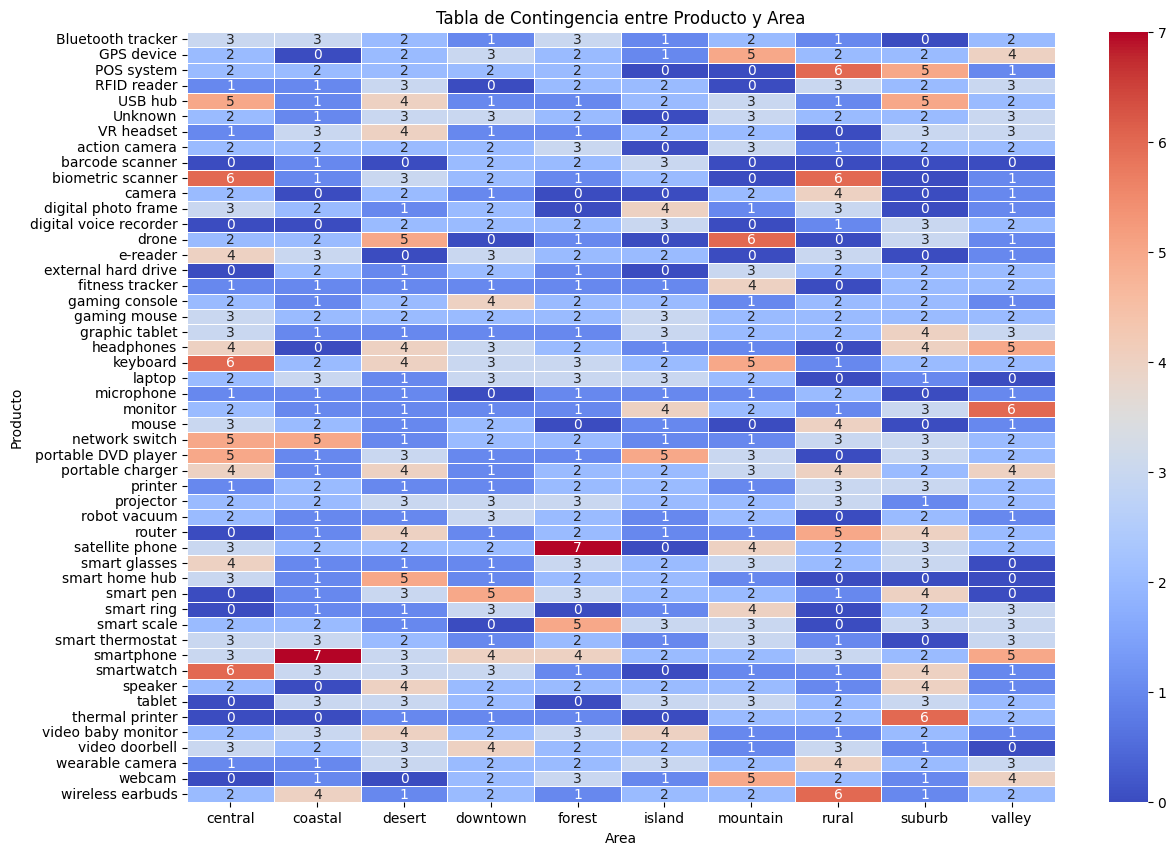

In [83]:
print("\nResultados de la prueba de Chi-cuadrado:")
print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")
print(f"Grados de libertad: {dof}")
# Visualizar la tabla de contingencia usando un mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True,
            cmap='coolwarm', linewidths=0.5, fmt='d')
plt.title('Tabla de Contingencia entre Producto y Area')
plt.show()

### informe

> # Etapa 6: Visualización de datos :


- Definir eda


In [84]:
eda = edaSQL.EDA(dataFrame=df_envio, HTMLDisplay=True)

### 1. **Analisis univariado**


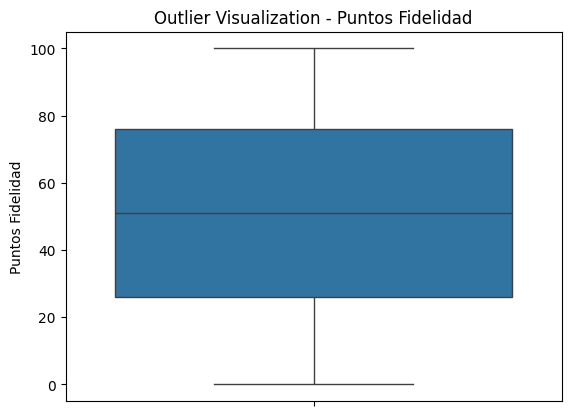

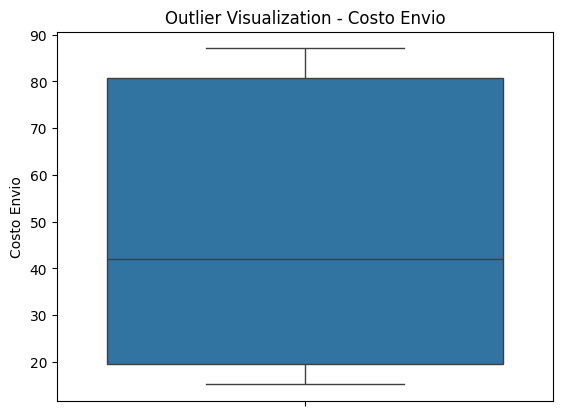

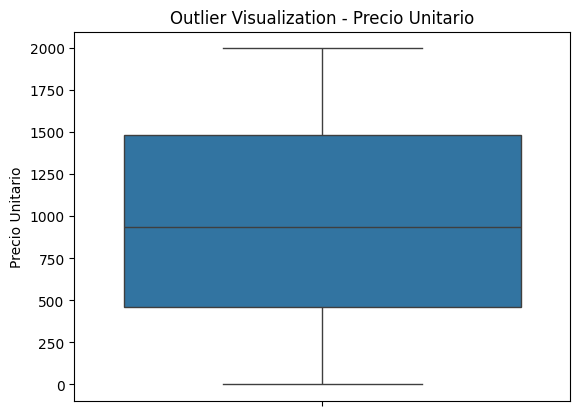

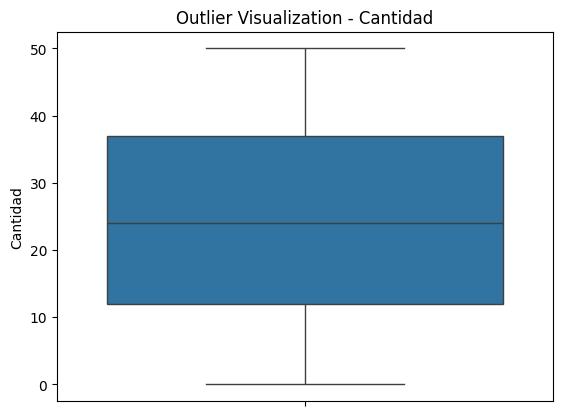

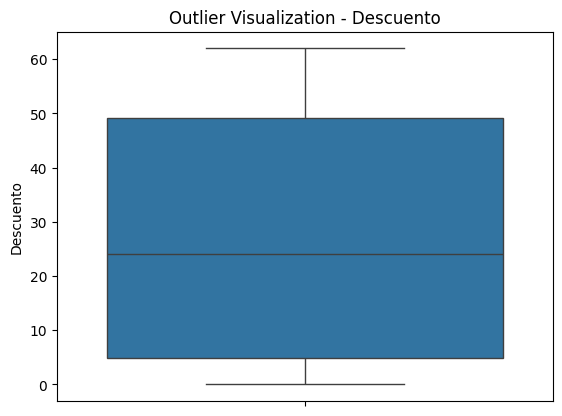

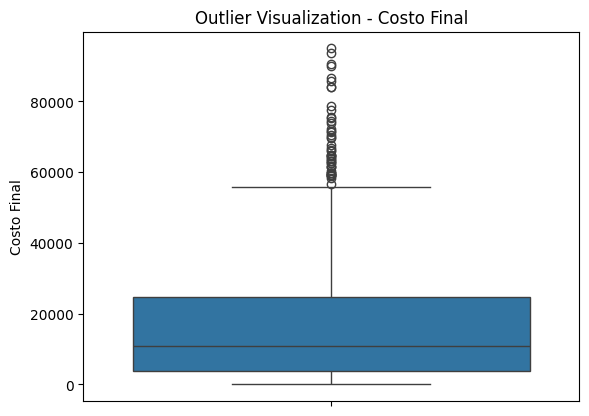

In [85]:
eda.outliersVisualization(plot="box")

### informe

### 2. **Analsis Bivariado**


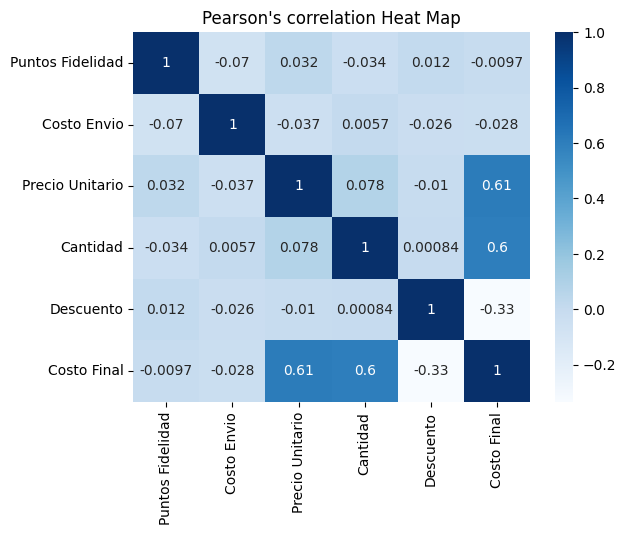

In [86]:
eda.pearsonCorrelation()

## informe

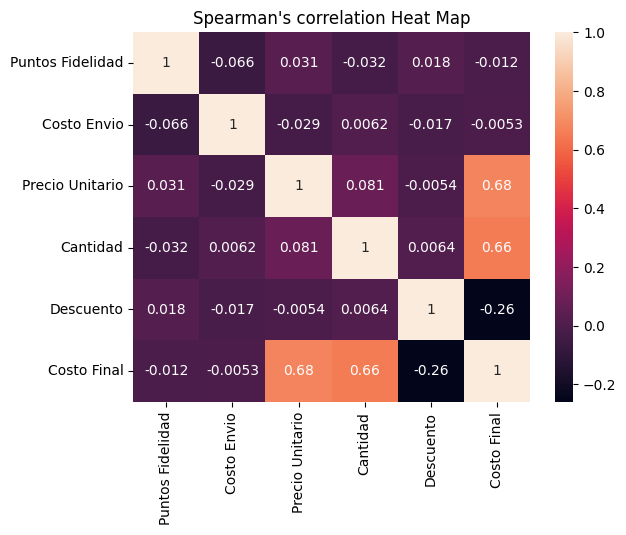

In [87]:
eda.spearmanCorrelation()

"informe"

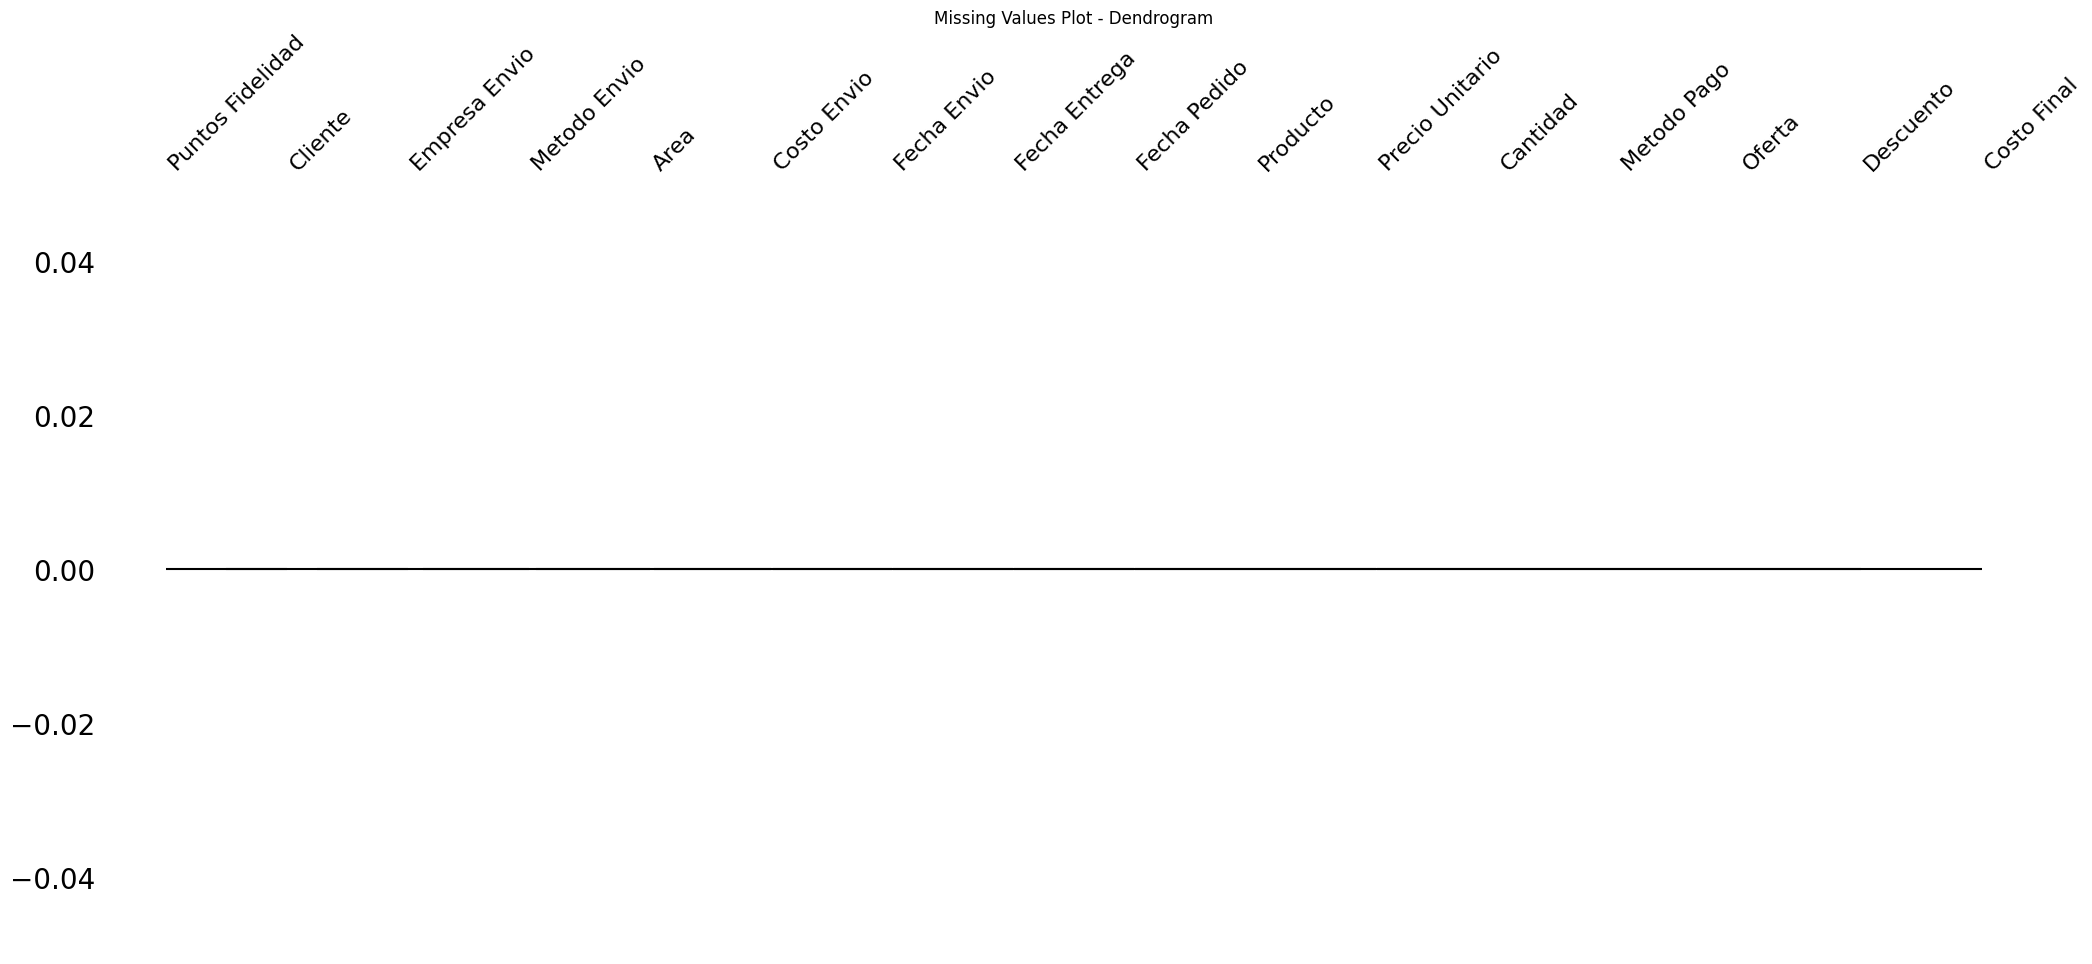

In [88]:
eda.missingValuesPlot(plot="dendrogram")

## Informe sobre la Calidad de los Datos: Análisis de Valores Faltantes

### Interpretación del Dendrograma

El dendrograma proporcionado muestra la relación entre las columnas del DataFrame con respecto a los valores faltantes. A continuación, se detallan las conclusiones derivadas de la interpretación del gráfico:

1. **No hay valores faltantes significativos**:

   - Observación: Todas las columnas están alineadas en el nivel 0 del eje Y.
   - Interpretación: Esta alineación sugiere que no hay valores faltantes significativos en ninguna de las columnas del DataFrame. Las columnas no presentan variabilidad en términos de datos ausentes, lo que indica una uniformidad en la completitud de los datos.

2. **Datos completos**:
   - Observación: La ausencia de agrupaciones o ramas distintas en el dendrograma.
   - Interpretación: La presencia de las columnas en el mismo nivel y sin formar agrupaciones o ramas separadas indica que las columnas del DataFrame tienen datos completos. No se observa ningún patrón distintivo de valores faltantes que destaque entre las diferentes columnas.

### Conclusión

El análisis del dendrograma revela que el DataFrame está compuesto por datos completos, sin valores faltantes significativos. Este resultado es ideal para el análisis de datos, ya que evita la necesidad de realizar tareas de imputación o eliminación de valores faltantes. Esto permite proceder con análisis más avanzados o el desarrollo de modelos de machine learning sin la preocupación de sesgos o inconsistencias introducidas por la ausencia de datos.


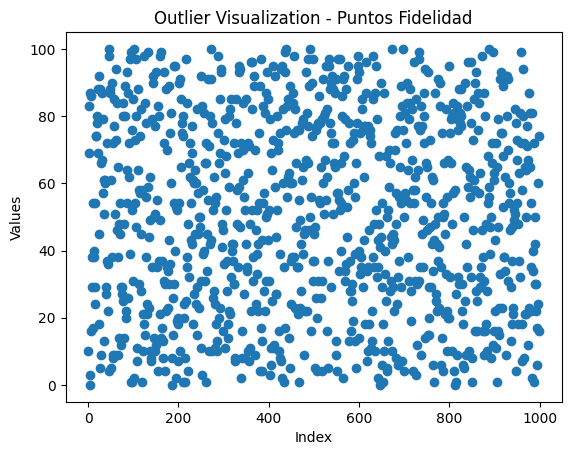

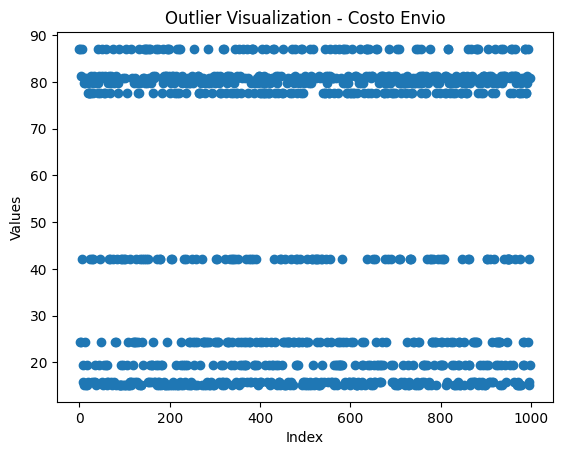

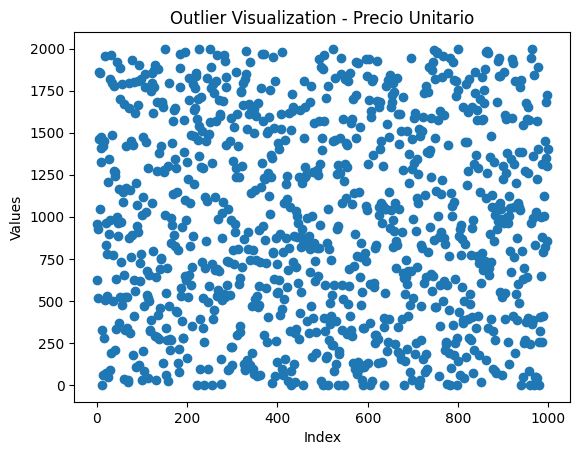

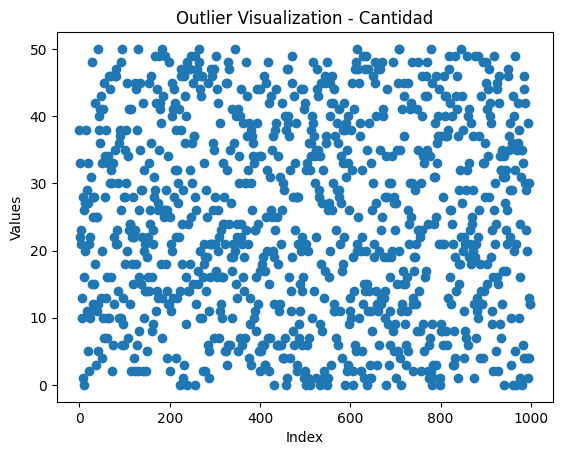

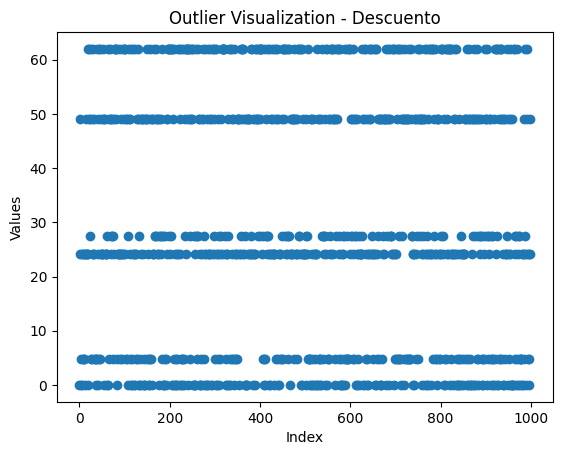

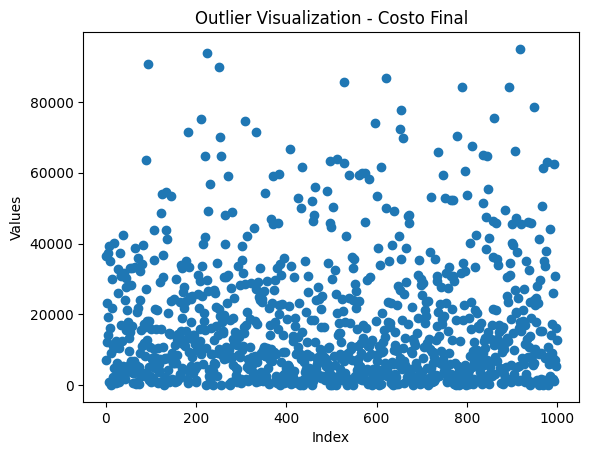

In [89]:
eda.outliersVisualization(plot="scatter")

### informe